In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_aer import AerSimulator

In [2]:
n = 5                # number of assets
N = 15              # number of spins
K = 2                # bits per asset
Ks = 5               # bits of slack variable

mu = np.array([0.12, 0.10, 0.15, 0.09, 0.11])      # expected return per share
prices = np.array([10, 12, 8, 15, 7])             # cost per share
B = 50                                            # budget
lam = 0.3                                        # risk aversion λ
alpha = 5.0                                        # penalty coefficient

# Example positive semidefinite covariance matrix
Sigma = np.array([
    [0.04, 0.01, 0.00, 0.00, 0.01],
    [0.01, 0.05, 0.01, 0.00, 0.00],
    [0.00, 0.01, 0.06, 0.02, 0.00],
    [0.00, 0.00, 0.02, 0.07, 0.01],
    [0.01, 0.00, 0.00, 0.01, 0.03]
])

upper_bounds = [3, 3, 3, 3, 3]   # upper bound search range

In [3]:
# --- 定义 Hamiltonian 函数, calculate by enumerating spins ---
def H_factor(s):
    
    # s is a list of spins (+1/-1), we need to map it to binary variables
    v = [(s[i]+1)//2 for i in range(len(s))]

    H = 0.0
    for i in range(n):
        for j in range(n):
            for p1 in range(K):
                for p2 in range(K):
                    idx_i = i*K + p1
                    idx_j = j*K + p2
                    coeff = (lam * Sigma[i,j] + alpha * prices[i] * prices[j]) * (2**p1) * (2**p2)
                    H += coeff * v[idx_i] * v[idx_j]
    
    for i in range(n):
        for p in range(K):
            idx = i*K + p
            coeff = - (mu[i] + 2 * alpha * B * prices[i]) * (2**p)
            H += coeff * v[idx]

    for i in range(n):
        for p1 in range(K):
            for p2 in range(Ks):
                idx1 = i*K + p1
                idx2 = n*K + p2
                coeff = 2 * alpha * prices[i] * (2**p1) * (2**p2)
                H += coeff * v[idx1] * v[idx2]

    for p1 in range(Ks):
        for p2 in range(Ks):
            idx1 = n*K + p1
            idx2 = n*K + p2
            coeff =alpha * (2**p1) * (2**p2)
            H += coeff * v[idx1] * v[idx2]

    for p in range(Ks):
        idx = n*K + p
        coeff = - alpha * (2 * B) * (2**p)
        H += coeff * v[idx]

    H += alpha * B * B
    return H

# --- 计算 Ising 系数 ---
def get_ising_coeffs(H_func):
    """
    严格计算 Ising 系数 h, J, C
    """
    # 枚举所有 2^N 自旋配置
    configs = np.array(list(itertools.product([1,-1], repeat=N)))
    H_values = np.array([H_func(s) for s in configs])

    num_terms = 1 + N + N*(N-1)//2  # 常数 + h_i + J_ij
    X = np.ones((2**N, num_terms))
    X[:,1:1+N] = configs

    # 填充上三角 s_i s_j
    idx = 1 + N
    for i in range(N):
        for j in range(i+1, N):
            X[:, idx] = configs[:,i]*configs[:,j]
            idx +=1

    coeffs, *_ = np.linalg.lstsq(X, H_values, rcond=None)

    C = coeffs[0]
    h = coeffs[1:1+N]  # 注意标准形式 H = h_i s_i + sum J_ij s_i s_j + C  ##### IMPORTANT: all things in positive manner #####
    J = np.zeros((N,N))
    idx = 1 + N
    for i in range(N):
        for j in range(i+1, N):
            J[i,j] = coeffs[idx]
            idx +=1

    return h, J, C

h, J, C = get_ising_coeffs(H_factor)

np.set_printoptions(precision=4, suppress=True)
print("h =", h)
print("J =", J)
print("C =", C)

h = [2174.967  4349.934  2609.9815 5219.963  1739.9655 3479.931  3262.5
 6525.     1522.4675 3044.935   217.5     435.      870.     1740.
 3480.    ]
J = [[   0.      500.012   300.0015  600.003   200.      400.      375.
   750.      175.0015  350.003    25.       50.      100.      200.
   400.    ]
 [   0.        0.      600.003  1200.006   400.      800.      750.
  1500.      350.003   700.006    50.      100.      200.      400.
   800.    ]
 [   0.        0.        0.      720.015   240.0015  480.003   450.
   900.      210.      420.       30.       60.      120.      240.
   480.    ]
 [   0.        0.        0.        0.      480.003   960.006   900.
  1800.      420.      840.       60.      120.      240.      480.
   960.    ]
 [   0.        0.        0.        0.        0.      320.018   300.003
   600.006   140.      280.       20.       40.       80.      160.
   320.    ]
 [   0.        0.        0.        0.        0.        0.      600.006
  1200.012   280.      560

In [4]:
# enumerate all possible states to verify
max_energy = -np.inf
min_energy = np.inf
min_energy_state = None
for state in range(2**N):
    z = np.array([1 if (state >> i) & 1 == 0 else -1 for i in range(N)])
    energy = z @ J @ z + h @ z + C
    max_energy = max(max_energy, energy) 
    if energy < min_energy:
        min_energy = energy
        min_energy_state = z

print("\nMax energy from enumeration:", max_energy)
print("Min energy from enumeration:", min_energy)
print("Min energy state from enumeration:", min_energy_state)


Max energy from enumeration: 93844.28900000025
Min energy from enumeration: -0.5800000004037429
Min energy state from enumeration: [-1  1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1]


In [5]:
def U_H(J, h, t):
    qc = QuantumCircuit(N)
    for i in range(N):
        if h[i] != 0:
            qc.rz(-2 * h[i] * t, i)
    for i in range(N):
        for j in range(i + 1, N):
            if J[i, j] != 0:
                qc.cx(i, j)
                qc.rz(-2 * J[i, j] * t, j)
                qc.cx(i, j)
    return qc

def U_x(B, t):
    qc = QuantumCircuit(N)
    for i in range(N):
        qc.rx(2 * B * t, i)
    return qc

def trotter_annealing(T=10, M=100, B=1.0):
    """Simulate quantum annealing using first-order Trotter decomposition."""
    dt = T / M
    qc = QuantumCircuit(N)
    qc.h(range(N))  # Initialize in |+> state
    for i in range(M):
        s = i / M
        qc.append(U_x(B * (1 - s), dt), range(N))
        qc.append(U_H(J, h, dt * s), range(N))
    return qc


def compute_energy(bitstring, J, h, C):
    """Compute Ising energy given spin configuration (+1/-1)."""
    #print(bitstring)
    S = np.array([1 if b == '0' else -1 for b in bitstring[::-1]])
    return S @ J @ S + np.dot(h, S) + C



In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler, Session

QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token="YOUR_IBM_QUANTUM_TOKEN_HERE",
    overwrite=True
)

In [24]:
service = QiskitRuntimeService()

backends = service.backends()
for backend in backends:
    print(backend.name, backend.num_qubits, backend.status().operational)
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=20
)
print("Selected backend:", backend.name)

qiskit_runtime_service.__init__:WARNING:2025-12-23 21:29:02,964: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-12-23 21:29:02,965: Loading instance: open-instance, plan: open


ibm_fez 156 True
ibm_torino 133 True
ibm_marrakesh 156 True


qiskit_runtime_service.backends:WARNING:2025-12-23 21:29:10,252: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-12-23 21:29:11,662: Using instance: open-instance, plan: open


Selected backend: ibm_torino


In [25]:
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
qc = trotter_annealing(T=1, M=100, B=1.0)
qc.measure_all()
isa_circuit = pm.run(qc)
print(f">>> Circuit ops (ISA): {isa_circuit.count_ops()}")

sampler = Sampler(mode=backend)

>>> Circuit ops (ISA): OrderedDict({'sx': 90737, 'rz': 65837, 'cz': 51078, 'measure': 15, 'barrier': 1})


In [26]:
job = sampler.run([(isa_circuit)])
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")
result = job.result()
print(result)

>>> Job ID: d559idhsmlfc739ghkdg
>>> Job Status: QUEUED
PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=4096, num_bits=15>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2025-12-23 13:29:48', stop='2025-12-23 13:29:54', size=4096>)])}, 'version': 2})


In [ ]:
# extract results
pub_result = result[0]
bitstrings = pub_result.data.meas.get_bitstrings()

energies = [compute_energy(bs, J, h, C) for bs in bitstrings]
print(min(energies))

-0.566999999960899


In [6]:
qc = trotter_annealing(T=10, M=1000, B=1) # TODO: how to choose parameters
qc.measure_all()
sim = AerSimulator()
result = sim.run(transpile(qc, sim), shots=10000).result()
counts = result.get_counts()

# Compute energies for each measurement
energies = []
min_energy = np.inf
ground_state = None
for bitstring, count in counts.items():
    E = compute_energy(bitstring, J, h, C)
    energies += [E] * count
    if E < min_energy:
        min_energy = E
        ground_state = np.array([1 if b == '0' else -1 for b in bitstring[::-1]])


In [7]:
# calculate asset number and slack variable
print("min energy:", min(energies))
print("ground state:", ground_state)
asset_counts = []
for i in range(n):
    count = 0
    for p in range(K):
        idx = i*K + p
        if ground_state[idx] == 1:
            count += 2**p
    asset_counts.append(count)

print("Asset counts:", asset_counts)
slack_value = 0
for p in range(Ks):
    idx = n*K + p
    if ground_state[idx] == 1:
        slack_value += 2**p
print("Slack variable value:", slack_value)

# Total cost , Expected return, Variance
total_cost = sum(prices[i] * asset_counts[i] for i in range(n))
expected_return = sum(mu[i] * asset_counts[i] for i in range(n))
variance = sum(Sigma[i,j] * asset_counts[i] * asset_counts[j] for i in range(n) for j in range(n))
print("Total cost:", total_cost)
print("Expected return:", expected_return)
print("Variance:", variance)

min energy: -0.5800000004037429
ground state: [-1  1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1]
Asset counts: [2, 0, 2, 0, 2]
Slack variable value: 0
Total cost: 50
Expected return: 0.76
Variance: 0.6


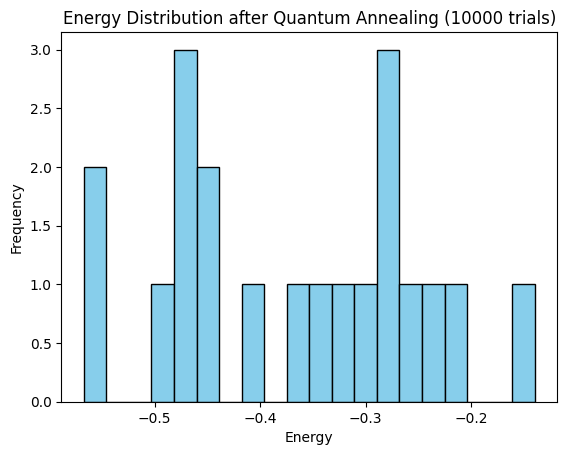

In [33]:

# Plot histogram
energies = np.array(energies)
# valid energy <= 0
valid_energies = energies[(~np.isinf(energies)) & (energies <= 0)]
plt.hist(valid_energies, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.title('Energy Distribution after Quantum Annealing (10000 trials)')
plt.show()

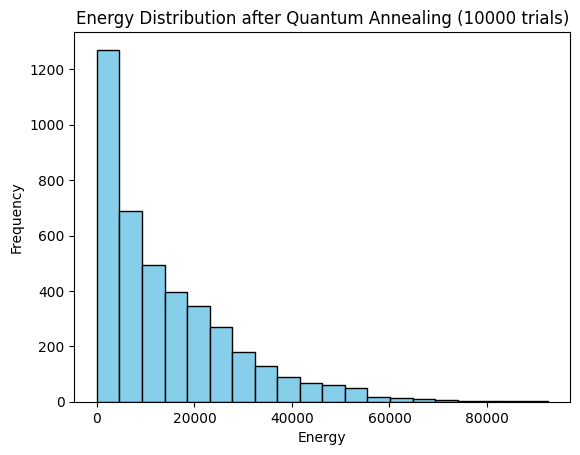

In [34]:
plt.hist(energies, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.title('Energy Distribution after Quantum Annealing (10000 trials)')
plt.show()